# Итоговое задание юнита 5.
# Компьютер говорит: "Нет".

Проект посвящён вопросам предоставления кредитов потенциальных заёмщиков. Необходимо создать модель скоринга на основе логистической регресси.

В процессе работы следует:
* провести анализ исходных данных;
* выявить закономерности в данных;
* выбрать наиболее удачную модель на основе анализа данных;
* провести подбор гиперпараметров модели;
* обучить модель предсказанию дефолта клиента;
* провести моделирование на основе тестовых данных;
* принять участие в соревновании на Kaggle.

## Импорт библиотек.

In [1]:
# Загружаем необходимые библиотеки.

# Базовые библиотеки.
import pandas as pd
from pandas import Series
import numpy as np

# Графика.
import matplotlib.pyplot as plt
import seaborn as sns

# Вспомогательные либы: кодировщики, стандартизаторы,..
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Библиотеки разбиения, перекрёстных оценок, прогнозаторов.
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# Метрика, оценки.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, accuracy_score

# Классификаторы.
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Библиотека работы с датой/временем.
import datetime

In [2]:
# Отключаем все возможные предупреждения.
import warnings
warnings.filterwarnings("ignore")

Проводим анализ: какие файлы присутствуют в рабочем каталоге.

In [3]:
import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./kaggle/input\currency.csv
./kaggle/input\DJ.W1FIN_131001_140501.csv
./kaggle/input\RTS.GAZP_131001_140501.csv
./kaggle/input\sample_submission.csv
./kaggle/input\test.csv
./kaggle/input\test.csv.zip
./kaggle/input\train.csv
./kaggle/input\train.csv.zip


## Блок функций.

In [4]:
#+++++++++++++++++++++++++++

def date_analise(data):
    """
    Функция применяется для проведения анализа временных характеристик
    """
    
    svalue = ['Год подачи заявки', 'Месяц подачи заявки', 'День недели подачи заявки', 'День месяца подачи заявки' ]
    data_size = len(data)
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 14)) 
    fig.subplots_adjust(wspace=0.1); fig.subplots_adjust(hspace=0.2)
    [ax[i,j].set_title(svalue[i+j], fontsize = 17) for i in range(2) for j in range(2)]; 

    # Года.
    years = data.app_date.dt.year.value_counts().reset_index().rename({'index': 'years', 'app_date': 'count'}, axis=1)
    years['years'] = years['years'].apply(int)
    years = years.sort_values(by='years')
    years['count'] = years['count'].apply(lambda x: x / data_size)
    years_val = years['years'].values
    
    # Месяц.
    months = data.app_date.dt.month.value_counts().reset_index().rename({'index': 'months', 'app_date': 'count'}, axis=1)
    months['months'] = months['months'].apply(int)
    months = months.sort_values(by='months')
    months['count'] = months['count'].apply(lambda x: x / data_size)
    months_val = months['months'].values
    
    # День месяца.
    days = data.app_date.dt.day.value_counts().reset_index().rename({'index': 'days', 'app_date': 'count'}, axis=1)
    days['days'] = days['days'].apply(int)
    days = days.sort_values(by='days')
    days['count'] = days['count'].apply(lambda x: x / data_size)
    days_val = days['days'].values
    
    # День недели.
    dweek = data.app_date.dt.dayofweek.value_counts().reset_index().rename({'index': 'day_of_week', 'app_date': 'count'}, axis=1)
    dweek['day_of_week'] = dweek['day_of_week'].apply(int)
    dweek = dweek.sort_values(by='day_of_week')
    dweek['count'] = dweek['count'].apply(lambda x: x / data_size)
    dweek_val = dweek['day_of_week'].values
  
    # Построение гистограмм
    # Годы
    sns.barplot(x='years', y='count', data=years, ci=None, orient='v',  ax=ax[0,0], order=years_val);
    ax[0,0].set_xlabel('years', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[0,0].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);

    # Месяцы
    sns.barplot(x='months', y='count', data=months, ci=None, orient='v',  ax=ax[0,1], order=months_val);
    ax[0,1].set_xlabel('months', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[0,1].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);
    
    # Дни
    sns.barplot(x='days', y='count', data=days, ci=None, orient='v',  ax=ax[1,0], order=days_val);
    ax[1,0].set_xlabel('days', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[1,0].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);
    
    # Дни недели
    sns.barplot(x='day_of_week', y='count', data=dweek, ci=None, orient='v',  ax=ax[1,1], order=dweek_val);
    ax[1,1].set_xlabel('day_of_week', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
    ax[1,1].set_ylabel('count', rotation=0, position=(0, 1.01), ha='left', fontsize=16);

#+++++++++++++++++++++++++++   

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds) :
    """
    Метод, позволяющий отрисовать полноту и точность как функции порога
    """
    
    plt.plot(thresholds, precisions[:-1], 'b--', label='Точность')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Полнота')
    plt.xlabel('Пopoг')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    plt.show()
    
#+++++++++++++++++++++++++++ 

def standart_scores(X_, Y_, model):
    """
    Функция расчёта стандартных оценок качества
    """
    
    # Строим прогноз.
    Y_pred_ = model.predict(X_)
    
    # Матрица неточностей.
    print('Основные оценки')
    print(classification_report(Y_, Y_pred_, digits=3))  
    
    print('Матрица неточностей')
    print(confusion_matrix(Y_, Y_pred_))
    
#+++++++++++++++++++++++++++ 

def plot_roc(X_tr, Y_tr, X_tt, Y_tt,
             fpr_tr, tpr_tr, fpr_tt,
             tpr_tt, model, label):
    """
    Функция построения графика ROC
    """
    
    Y_train_prob = model.predict_proba(X_tr)
    Y_train_prob = Y_train_prob[:,1]
    Y_test_prob = model.predict_proba(X_tt)
    Y_test_prob = Y_test_prob[:,1]
    
    fpr_tr, tpr_tr, train_threshold = roc_curve(Y_tr, Y_train_prob)
    train_roc_auc = roc_auc_score(Y_tr, Y_train_prob)
    
    fpr_tt, tpr_tt, test_threshold = roc_curve(Y_tt, Y_test_prob)
    test_roc_auc = roc_auc_score(Y_tt, Y_test_prob)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr_tr, tpr_tr, label = 'Train')
    plt.plot(fpr_tt, tpr_tt, label = 'Test')
    plt.title(f'{label}\nTrain ROC AUC = {round(train_roc_auc, 2)} Test ROC AUC = {round(test_roc_auc, 2)}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
#+++++++++++++++++++++++++++ 

## 1. Предварительная подготовка.

Итак: у нас есть файл с тренеровочным и тестовым набором. Загружаем их.

In [5]:
train = pd.read_csv('./kaggle/input/train.csv') # Тренеровочный набор.
test = pd.read_csv('./kaggle/input/test.csv')   # Тестовый набор.

Проведём беглый обзор данных.

In [6]:
train.head() # Тренеровочный набор.

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
train.info() # Тренеровочный набор.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [8]:
test.head() # Тестовый набор.

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [9]:
test.info() # Тестовый набор.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

Мы видим, что тренеровочный набор содержит 19 признаков, когда тестовая - 18. Естественно, что в тестовом наборе нет целевого признака "default". Количество записей в тренеровочном и тестовом наборах равна 73799 и 36349 соответственно.

По условиям задачи есть следующие признаки:
* client_id - идентификатор клиента;
* education - уровень образования;
* sex - пол заемщика;
* age - возраст заемщика;
* car - флаг наличия автомобиля;
* car_type - флаг автомобиля иномарки;
* decline_app_cnt - количество отказанных прошлых заявок;
* good_work - флаг наличия "хорошей" работы;
* score_bki - скоринговый балл по данным из БКИ;
* bki_request_cnt - количество запросов в БКИ;
* home_address - категоризатор домашнего адреса;
* work_address - категоризатор рабочего адреса;
* income - доход заемщика;
* foreign_passport - наличие загранпаспорта;
* sna - связь заемщика с клиентами банка;
* first_time - давность наличия информации о заемщике;
* region_rating - рейтинг региона;
* app_date - дата подачи заявки;
* default - флаг дефолта по кредиту.

## 2. Анализ данных.
## 2.1. Работа с пропусками.

 Проверим пропуски.

Тренеровочный набор


client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

Тестовый набор


client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

Text(0.5, 1.0, 'Пропуски тестового набора')

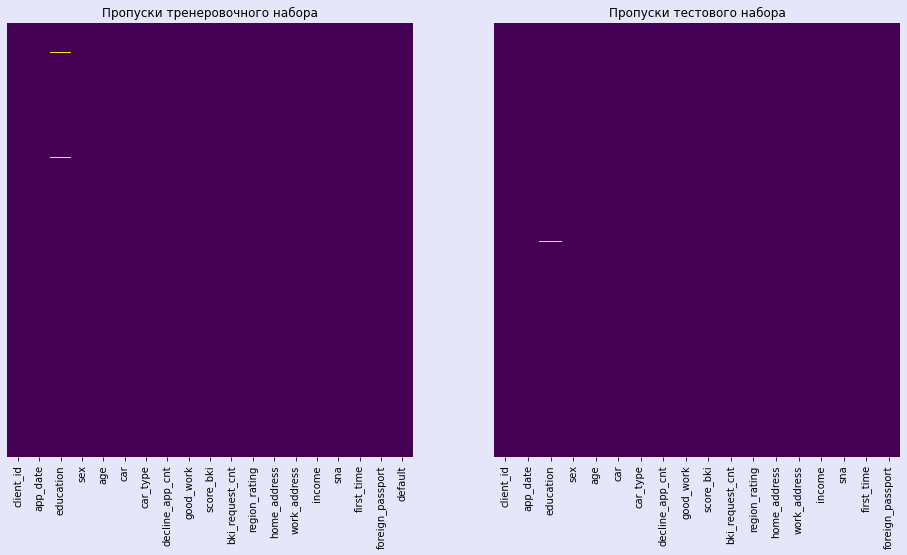

In [10]:
print('Тренеровочный набор')
display(train.isnull().sum()) # Тренеровочный набор.
print('Тестовый набор')
display(test.isnull().sum())  # Тестовый набор.

# Визуализируем пропуски.
fig, ax = plt.subplots(1, 2, figsize=(16,8), facecolor="Lavender")
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax[0]);
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax[1]);

# Подписываем.
ax[0].set_title("Пропуски тренеровочного набора")
ax[1].set_title("Пропуски тестового набора")

Есть пропуски по признаку "education". Пропусков мало, они составляют менее 0.5%. Их необходимо либо удалить, либо заполнить. Посмотрим, что можно сделать.

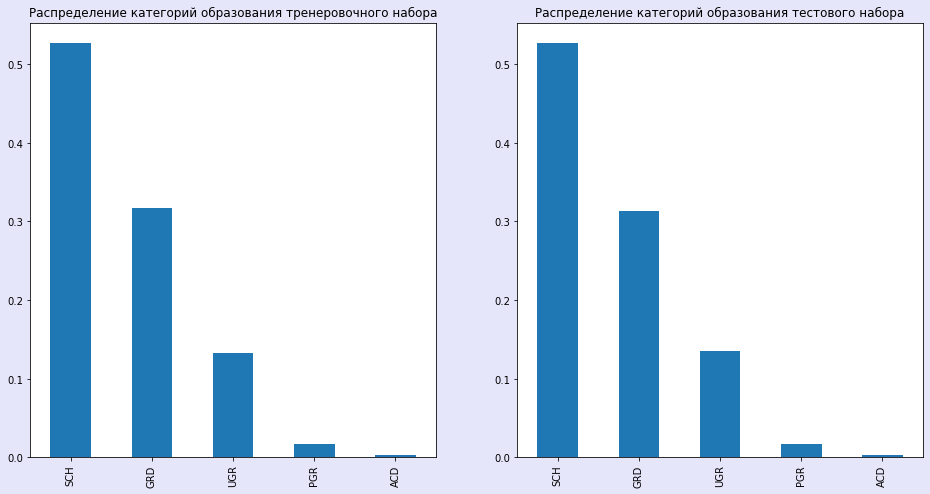

In [11]:
# Визуализируем распределение уровней образования.
fig, ax = plt.subplots(1, 2, figsize=(16,8), facecolor="Lavender")
train['education'].value_counts().apply(lambda x: x/len(train)).plot.bar(ax=ax[0])
test['education'].value_counts().apply(lambda x: x/len(test)).plot.bar(ax=ax[1])

# Подписываем.
ax[0].set_title("Распределение категорий образования тренеровочного набора");
ax[1].set_title("Распределение категорий образования тестового набора");

Как видно из результатов, доли каждой категории в наборах равны. Это хорошо. Ввиду того, что пропусков мало, то можно удалить их, но я предлагаю заполнить их модой.

In [12]:
tr_mode = train['education'].mode().loc[0] # Мода тренеровочного набора.
tt_mode = train['education'].mode().loc[0] # Мода тестового набора.

# Распечатываем их.
print(f'Мода тренеровочного набора: {tr_mode};\nМода тестового набора: {tt_mode}.')

Мода тренеровочного набора: SCH;
Мода тестового набора: SCH.


Неудивительно (смотрим на графики), заполняем пропуски.

In [13]:
train['education'].fillna(tr_mode, inplace=True)
test['education'].fillna(tt_mode, inplace=True)

Контрольная проверка на пропуски.

In [14]:
print(f'Количество пропусков тренеровочного набора: {train.isnull().sum().sum()};')
print(f'Количество пропусков тестового набора: {test.isnull().sum().sum()}.')

Количество пропусков тренеровочного набора: 0;
Количество пропусков тестового набора: 0.


Отлично.

## 2.2. Работа с признаками.

### app_date.
По первым записям видно, что это даты. Проверим, какого типа данных вышеуказанный признак.

In [15]:
train.app_date.apply(type).value_counts()

<class 'str'>    73799
Name: app_date, dtype: int64

Преобразуем этот столбец строк в удобный формат типа даты.

In [16]:
train.app_date = pd.to_datetime(train.app_date) # Тренеровочный набор.
test.app_date = pd.to_datetime(train.app_date)  # Тестовый набор.

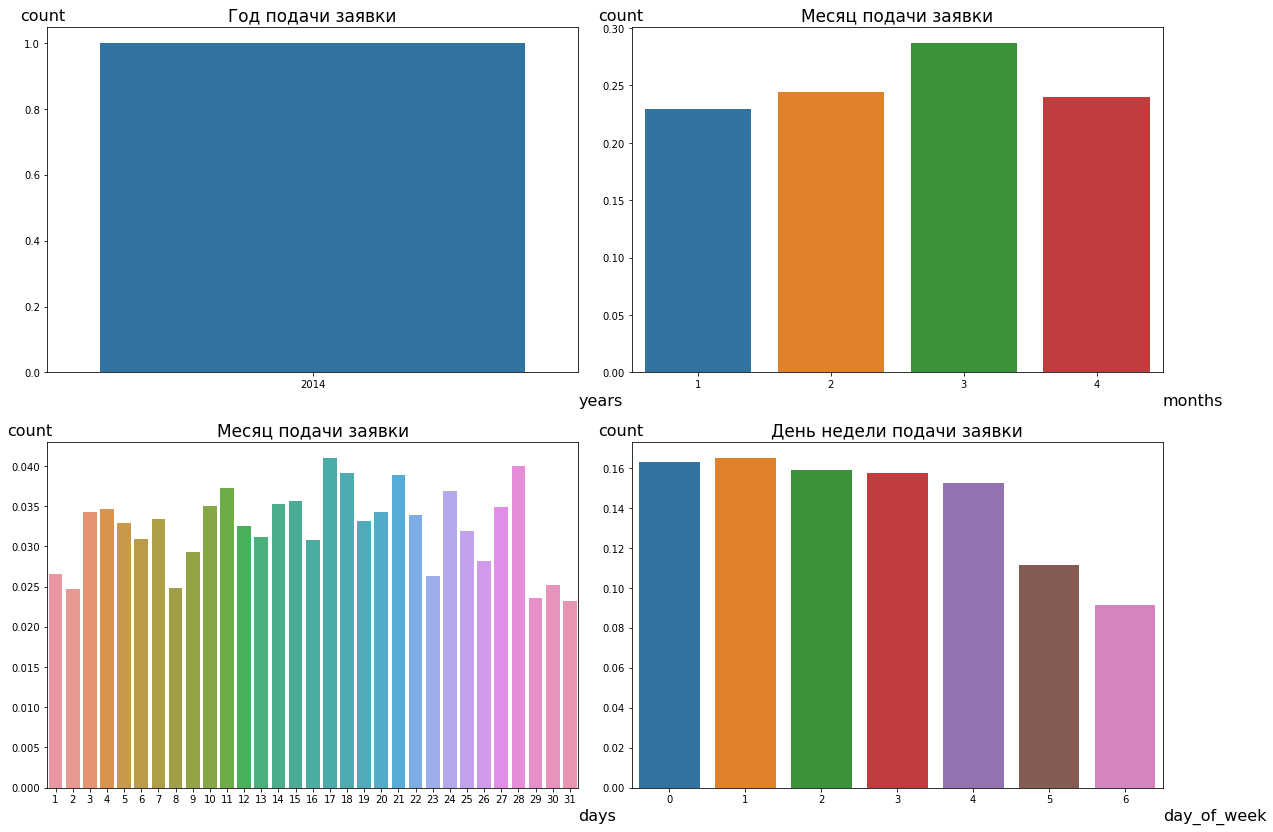

In [17]:
date_analise(train) # Тренеровочный набор

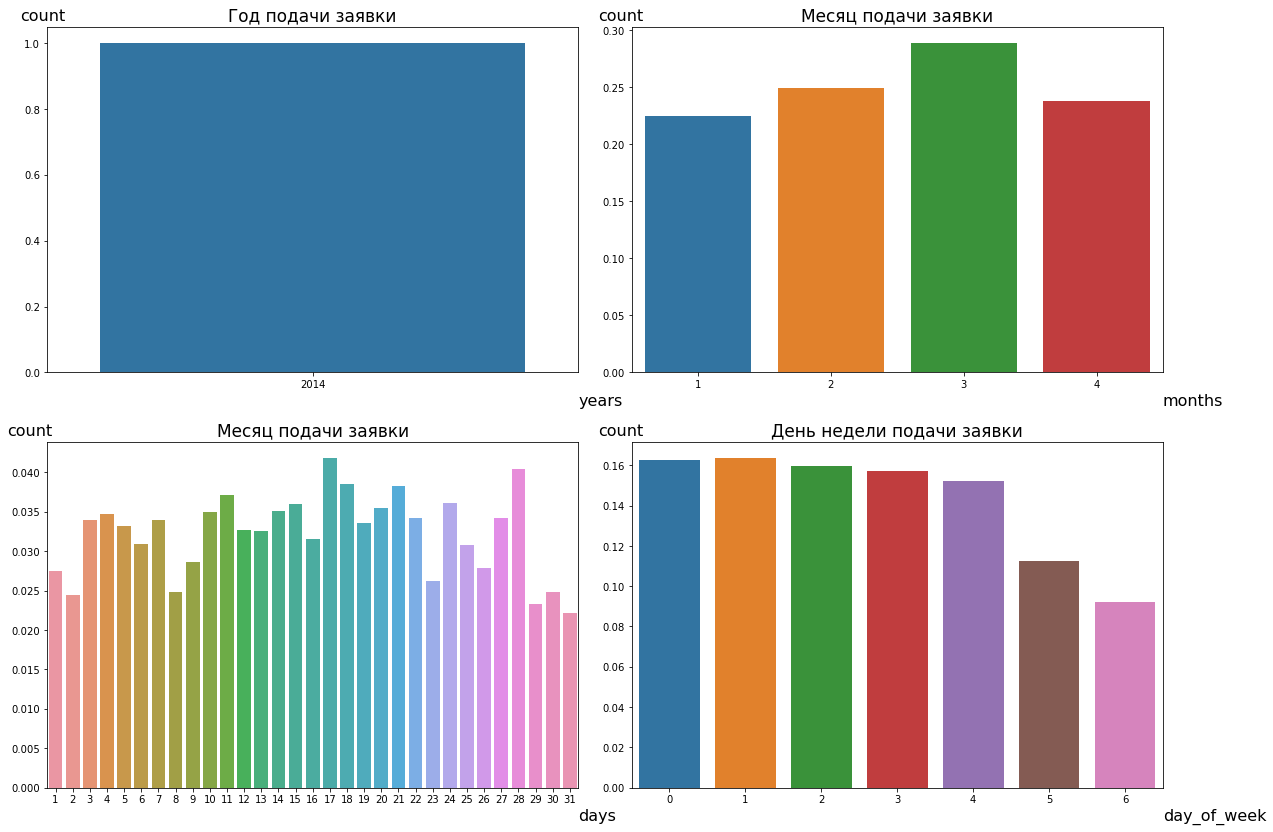

In [18]:
date_analise(test) # Тестовый набор

Итак, что мы видим.. Год везде один и тот же 2014, данные предоставлены только за 4 месяца. Как и ожидается, 31 число одно из самых редких по понятным причинам (всего 2 месяца таких), но и сильно не выбивается из общей канвы, как в проекте про рестораны. И по понятным причинам воскресение не самый популярный день подачи заявок. Данные удачно стратифицированы, доли совпадают друг с другом
Создадим новые признаки.

In [19]:
# Первый день в датасэте - 1 января 2014.
start_day = train.app_date.min()

# День обращения клиента
train['app_date_day'] = (train.app_date - start_day).dt.days.astype('int')
test['app_date_day'] = (test.app_date - start_day).dt.days.astype('int')

# День недели обращения клиента
train['app_date_dweek'] = train.app_date.dt.dayofweek
test['app_date_dweek'] = test.app_date.dt.dayofweek

# Месяц обращения клиента
train['app_date_month'] = train.app_date.dt.month
test['app_date_month'] = test.app_date.dt.month

## 2.3. Дополнительные данные.

В целом данные, которыми мы вынуждены оперировать, представляют уникальную информацию о клиенте. Они не содержат каких-либо макроэкономических параметров, которые, как я считаю, для финансового учреждения важны. Возможно, когда происходит резкое падение курса национальной валюты, имеет смысл быть более осторожным и не давать кредиты (это я так думаю). Поэтому я решил добавить некую информацию по дням (которые есть), описывающие характер экономических показателей в стране. Я предлагаю брать курса рубля к доллару плюс отношение курса к медиане за последние 35 дней. Это позволит не только на каждый день знать курс, но знать тенденцию курса рубля.
Для этих целей из открытых источников ([тут](https://www.finam.ru)) была взята информация по курсу валют и затем подготовлено отдельный файл. Загрузим его.

In [20]:
# Загружаем.
curr_data = pd.read_csv('./kaggle/input/currency.csv')

# Что получилось?
display(curr_data)

,app_date,rub,trand
0,2014-01-01,32.84,0.999087
1,2014-01-02,33.11,1.007301
2,2014-01-03,33.20,1.010040
3,2014-01-04,33.18,1.009431
4,2014-01-05,33.18,1.009431
...,...,...,...
115,2014-04-26,36.03,1.011226
116,2014-04-27,36.02,1.010946
117,2014-04-28,35.81,1.005052
118,2014-04-29,35.63,1.000000


Здесь:
* app_date - дата;
* rub - курс рубля к доллару США;
* trand - тенденция (рост/падение).

In [21]:
# Преобразуем к нужному типу app_date датасэта curr_data.
curr_data.app_date=curr_data.app_date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

# Обновляем исходные датасеты новой информацией по полю app_date.
train = train.merge(curr_data, on='app_date')
test = test.merge(curr_data, on='app_date')

#train.rub = train.rub ** train.score_bki
#test.rub = test.rub ** test.score_bki

Посмотрим, что получилось.

In [22]:
print('Тренеровочный набор.')
train.head(5)

Тренеровочный набор.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,app_date_day,app_date_dweek,app_date_month,rub,trand
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,18000,4,1,N,0,31,5,2,35.11,1.054354
1,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,30000,1,4,Y,0,31,5,2,35.11,1.054354
2,25947,2014-02-01,GRD,M,41,N,N,0,1,-2.166293,...,12000,1,3,N,0,31,5,2,35.11,1.054354
3,25572,2014-02-01,SCH,F,42,Y,N,0,0,-2.594199,...,26000,4,1,N,0,31,5,2,35.11,1.054354
4,25646,2014-02-01,SCH,F,53,N,N,0,0,-2.508767,...,30000,1,3,N,0,31,5,2,35.11,1.054354


In [23]:
print('Тестовый набор.')
test.head(5)

Тестовый набор.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,app_date_day,app_date_dweek,app_date_month,rub,trand
0,74835,2014-02-01,GRD,M,29,Y,Y,0,0,-2.271884,...,2,50000,1,4,N,31,5,2,35.11,1.054354
1,75683,2014-02-01,UGR,M,50,Y,Y,0,0,-1.691339,...,2,30000,1,3,Y,31,5,2,35.11,1.054354
2,106331,2014-02-01,SCH,F,41,N,N,0,0,-2.800324,...,3,40000,2,2,N,31,5,2,35.11,1.054354
3,86253,2014-02-01,SCH,M,23,N,N,1,0,-2.784103,...,3,30000,1,2,N,31,5,2,35.11,1.054354
4,60455,2014-02-01,GRD,M,36,N,N,0,0,-1.454279,...,3,50000,4,2,N,31,5,2,35.11,1.054354


### 2.4. Анализ признаков по типам.
По аналогии с предварительным заданием к проекту разобьём признаки на категориальные, бинарные и числовые.

In [24]:
# По аналогии с предварительным заданием.
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_date_dweek', 'app_date_month', 'education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'trand', 'rub', 'app_date_day']

### Числовые признаки.

По аналогии с подготовительным заданием проекта посмотрим распределение числовые признаки.

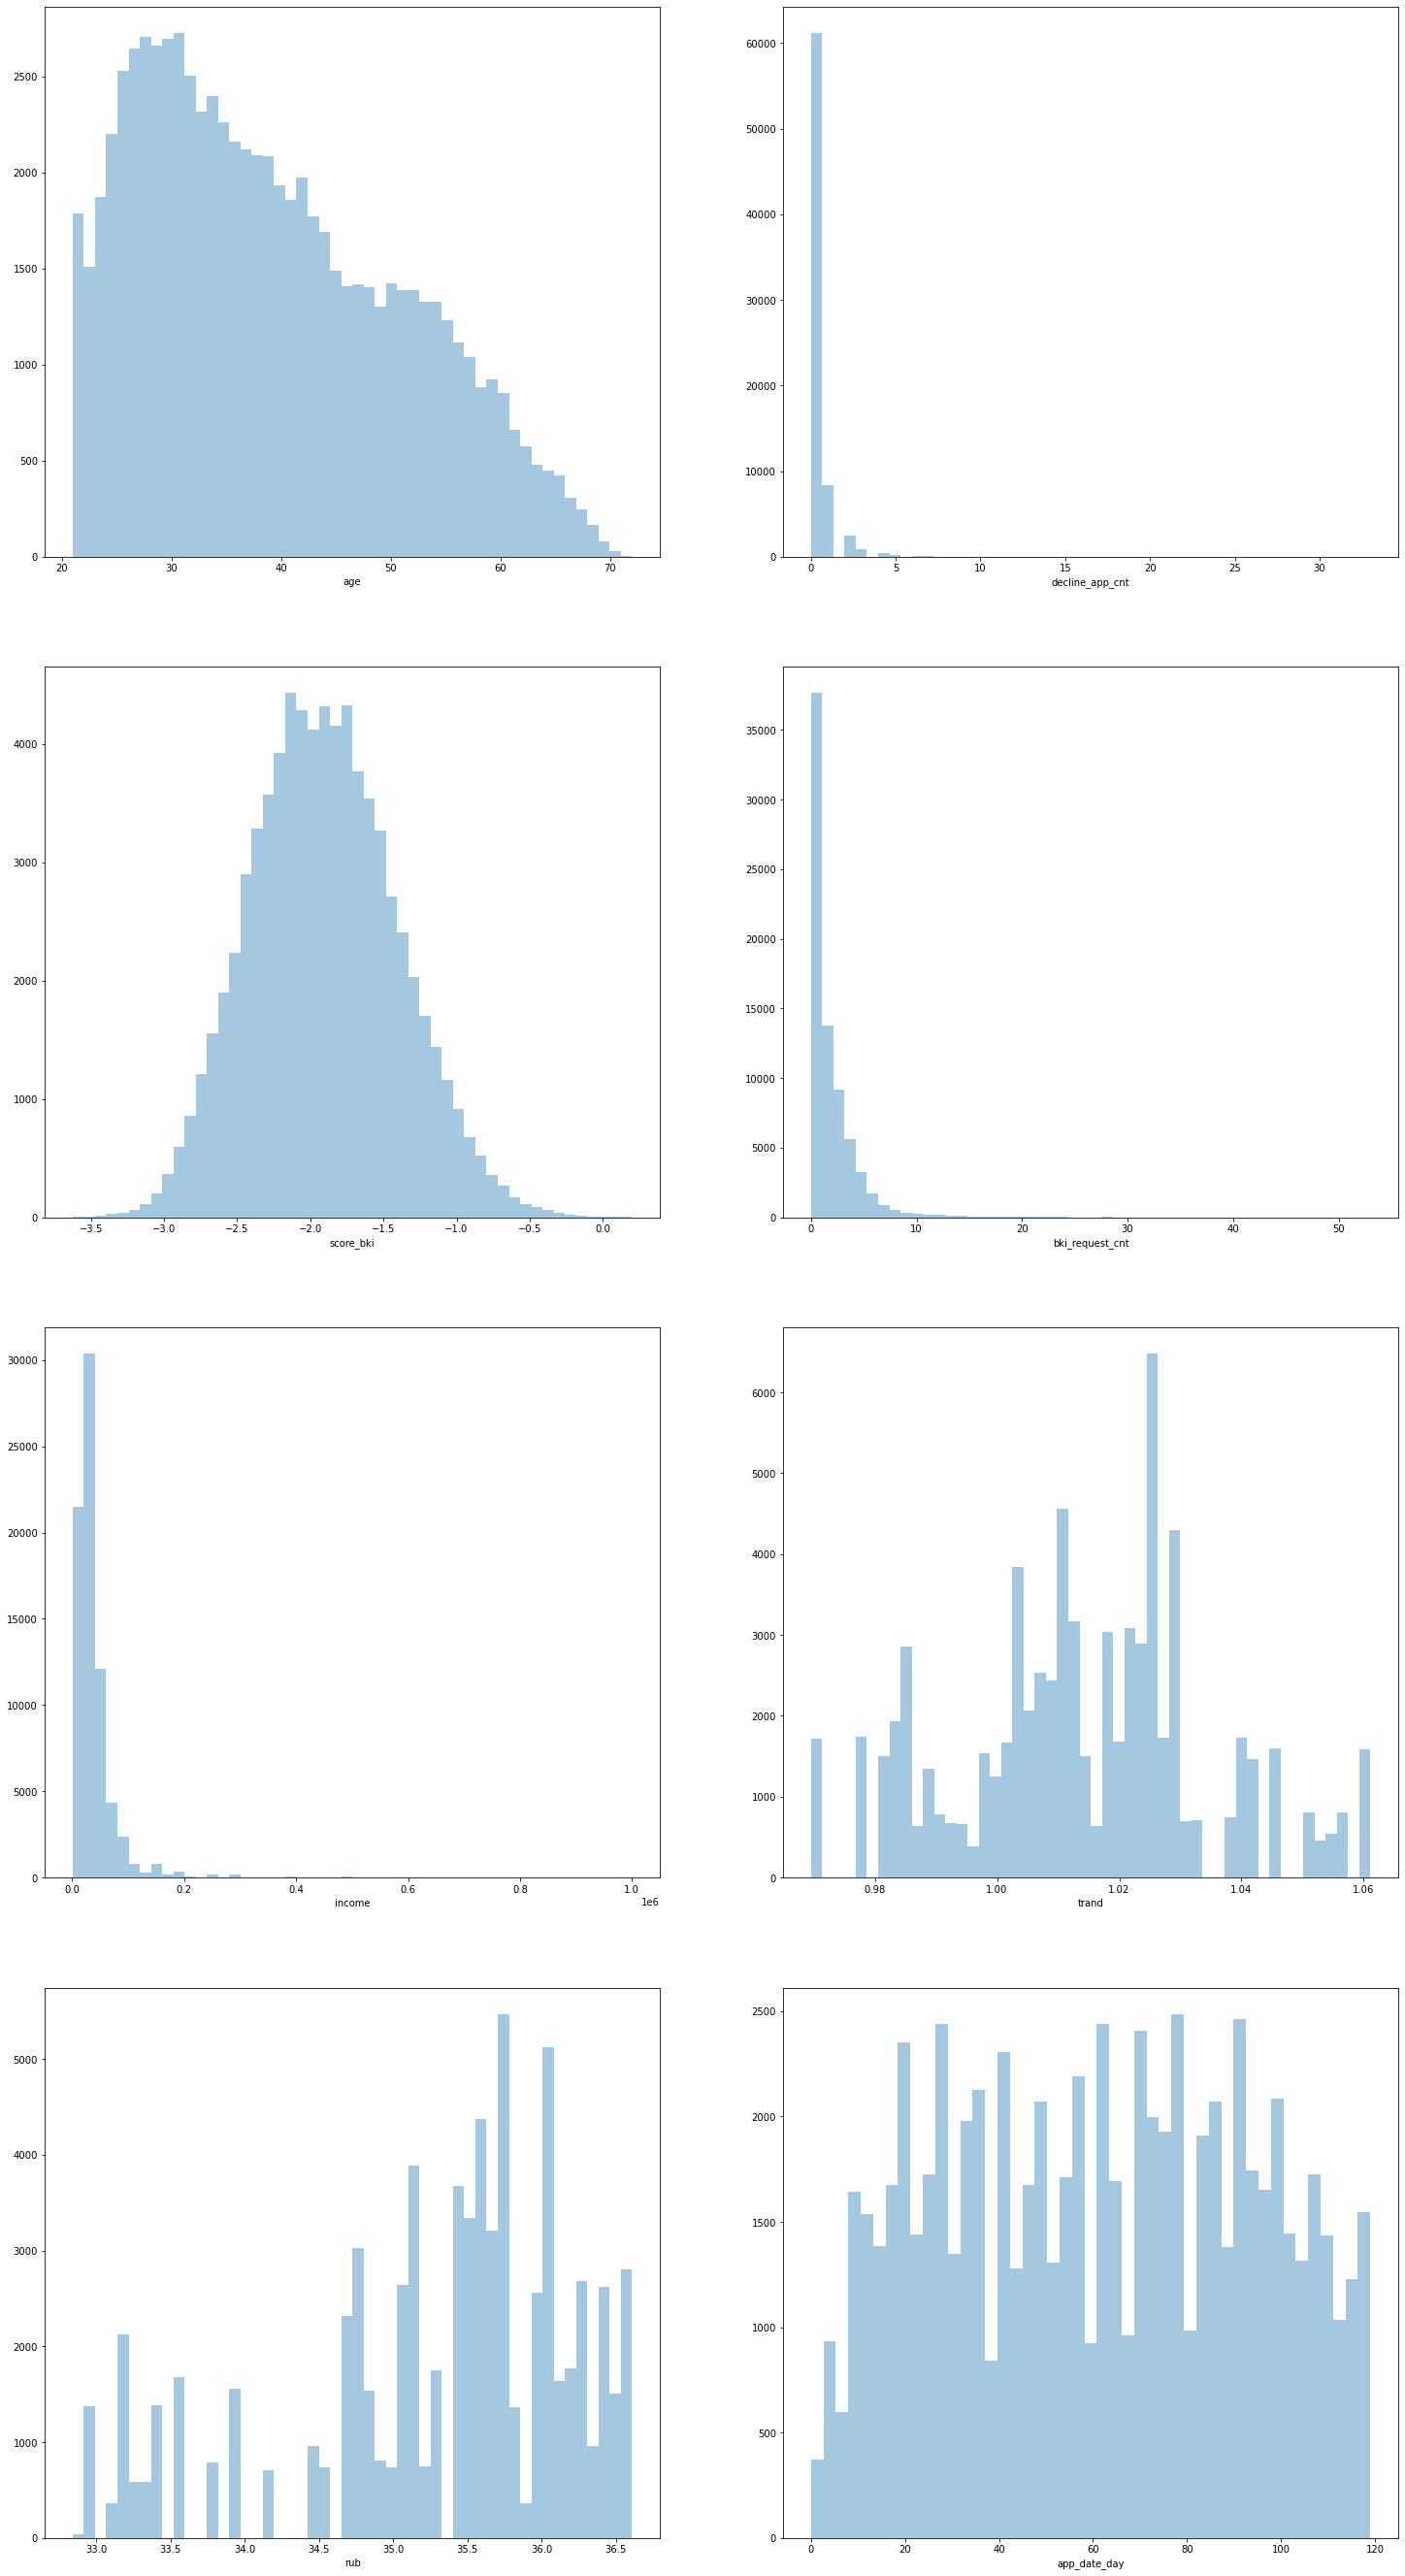

In [25]:
fig, axes = plt.subplots(4, 2, figsize=(25,48))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Как видим, значения по категриям могут сильно отличаться, плюс распределения имеют тяжёлый хвост за исключением "score_bki". Поэтому прологарифмируем числовые признаки за исключением "score_bki"  и двух новых признаков.

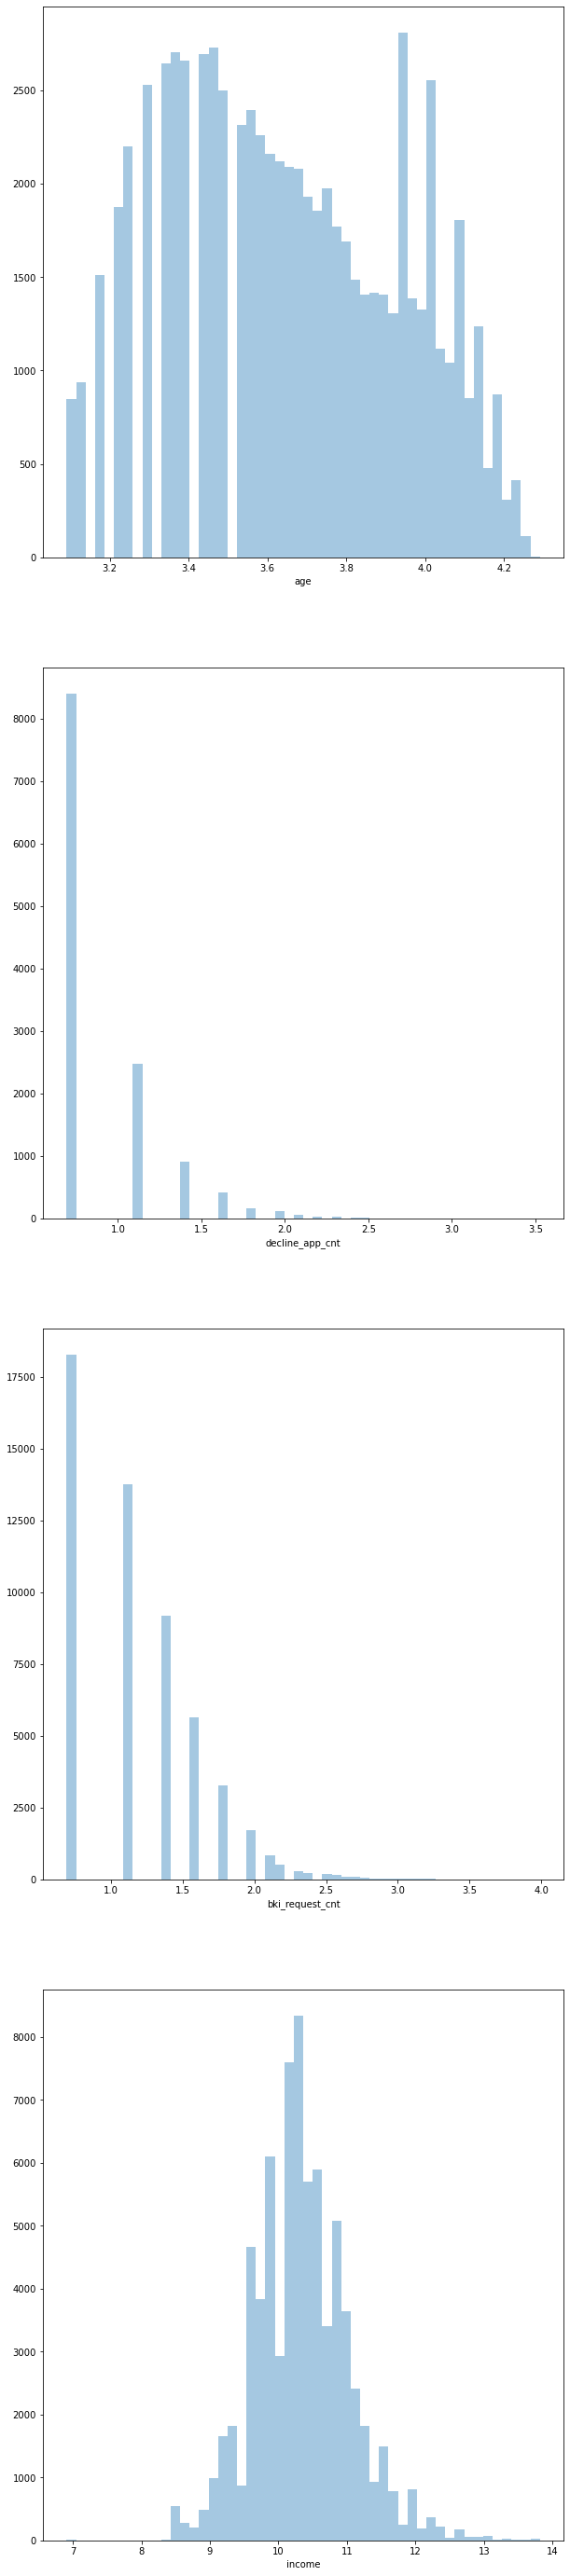

In [26]:
num_cols_ = num_cols.copy()
num_cols_.remove('score_bki')
num_cols_.remove('trand')
num_cols_.remove('rub')
num_cols_.remove('app_date_day')
fig, axes = plt.subplots(len(num_cols_), 1, figsize=(10, 50))
for col, i in zip(num_cols_, range(len(num_cols_))):
    train[col] = np.log(train[col] + 1)
    test[col] = np.log(test[col] + 1)
    sns.distplot(train[col][train[col] > 0].dropna(), kde = False, rug=False, ax=axes.flat[i])

Посмотрим на распределение целевой признак.

Соотношение в долях: [0.87300641 0.12699359]


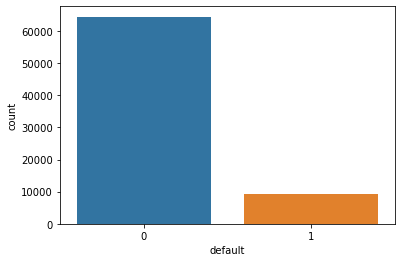

In [27]:
sns.countplot(train['default']) # Тренеровочный набор.
print(f'Соотношение в долях: {train.default.value_counts(normalize=True).values}')

Целевой класс, он же положительный (так будем считать, так как он есть цель), составляет лишь 12%. Изменять количество данных (оверсэмплинг/андерсэмплинг ) неправильно, так как алгоритм должен научиться работать на несбалансированных данных.

Проведём корреляционный анализ.

<AxesSubplot:>

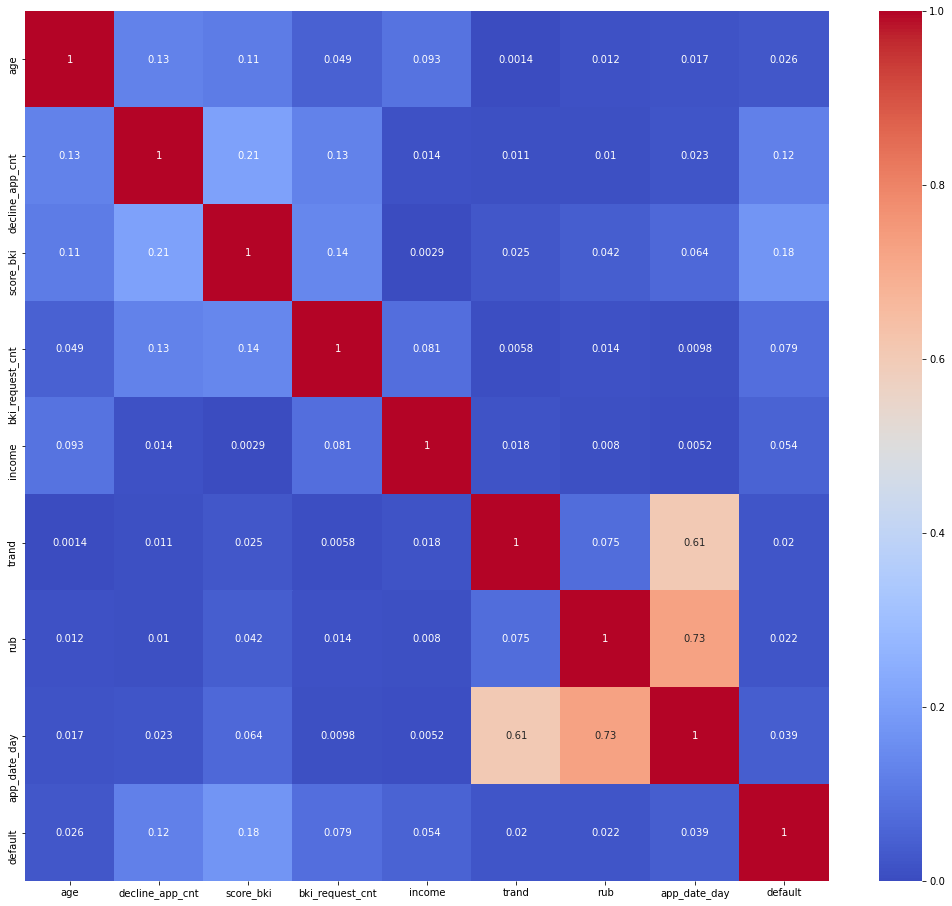

In [28]:
plt.figure(figsize=(18,16))
sns.heatmap(train[num_cols + ['default']].corr().abs(), vmin=0, vmax=1, annot=True, cmap= 'coolwarm')

Корреляция есть. Очень радует, что новые переменные зацепились со старыми! Построим численное распределение признаков.

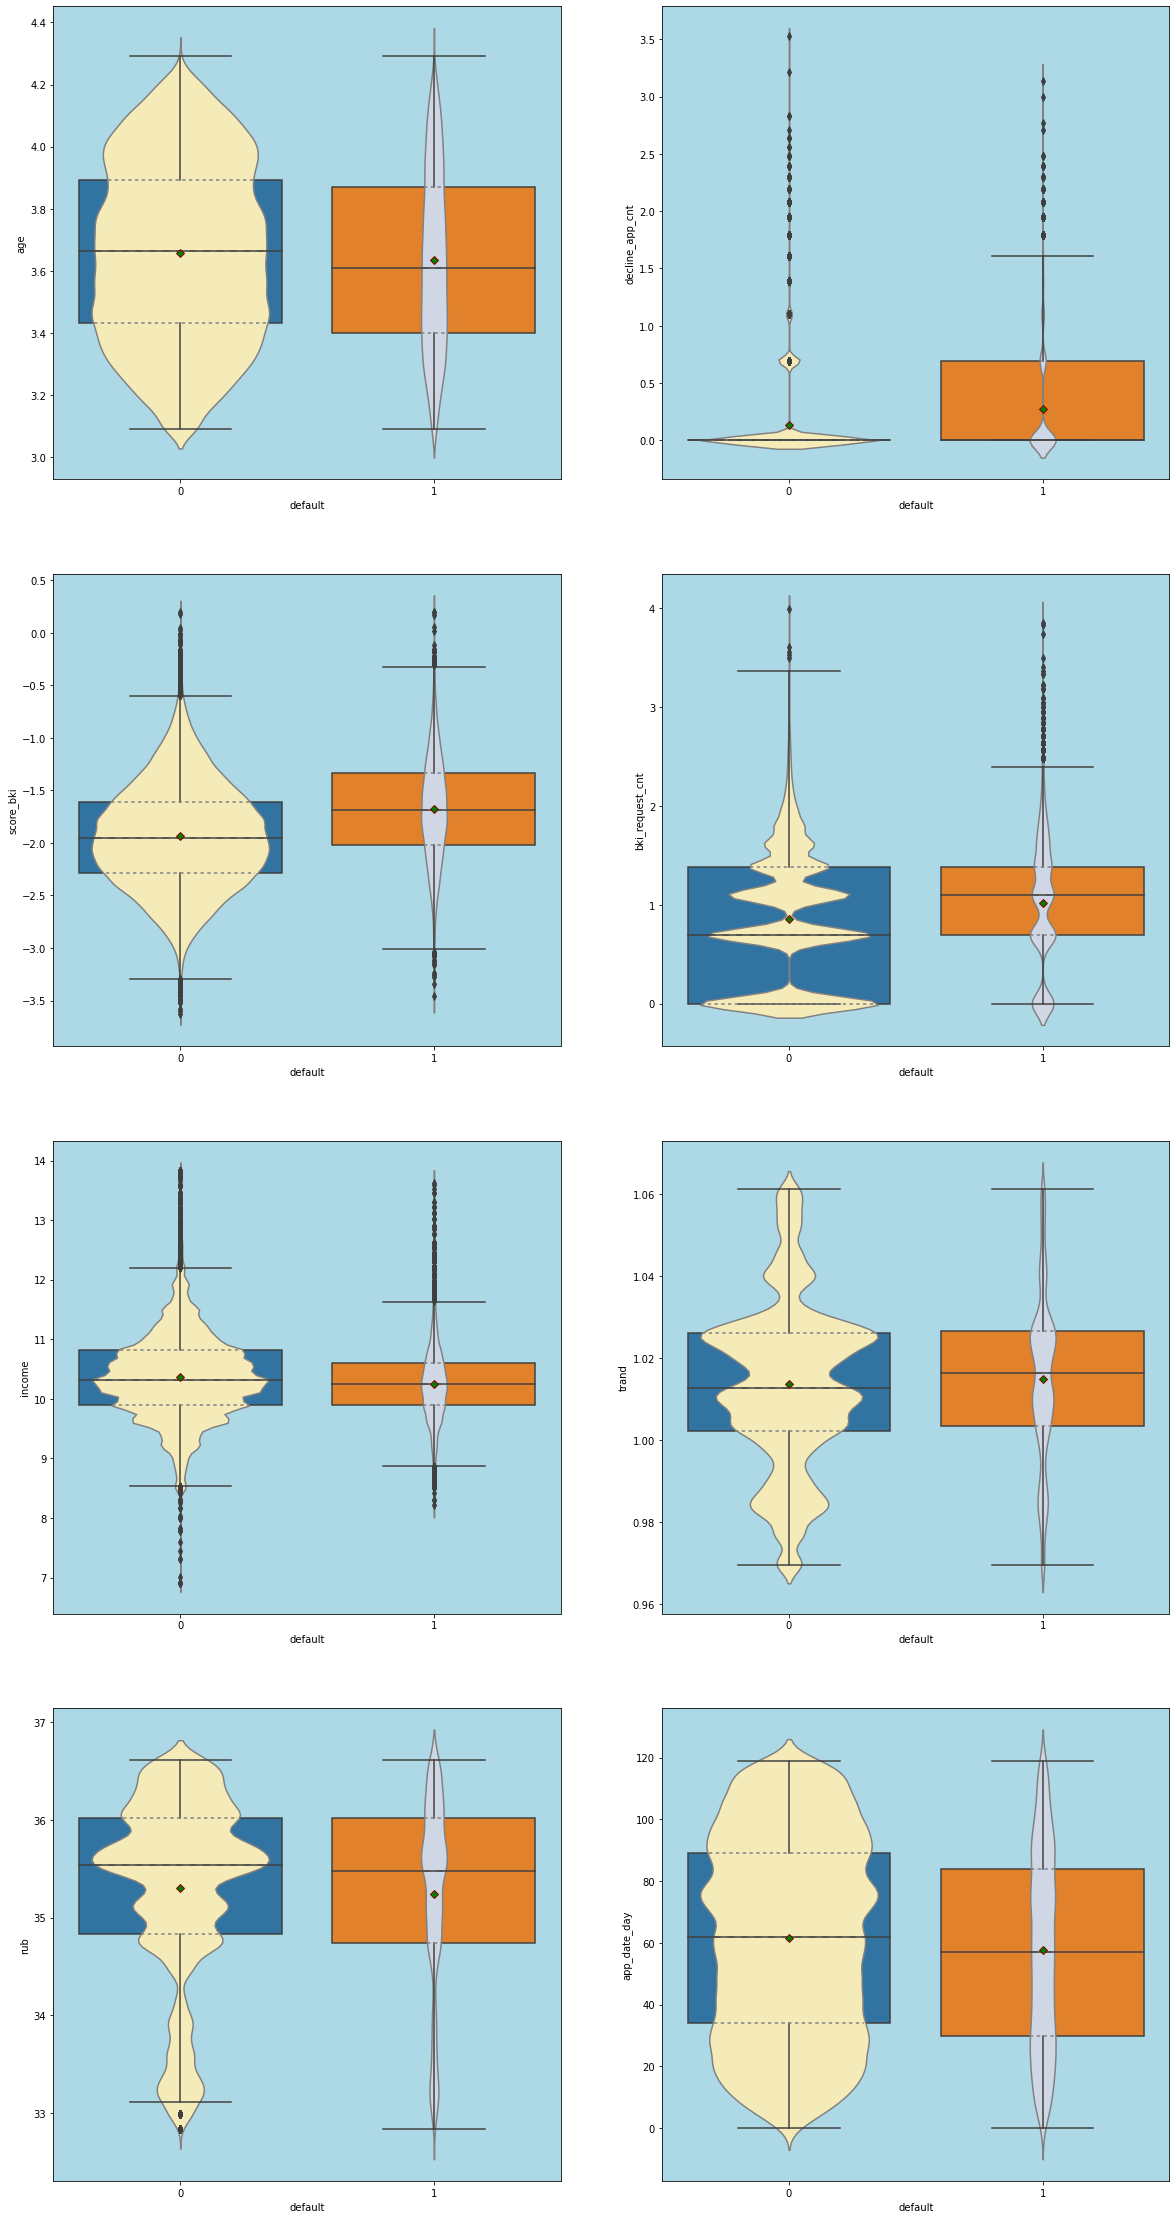

In [29]:
fig, axes = plt.subplots(4, 2, figsize=(20, 40))
mean_props = dict(marker='D', markeredgecolor='DarkRed', markerfacecolor='Green')
[axes.flat[i].set_facecolor('LightBlue') for i in range(0, 8)]


for col, i in zip(num_cols, range(8)):
    sns.boxplot(x=train.default, y=train[col], showmeans=True, meanprops=mean_props, ax=axes.flat[i])
    sns.violinplot(x=train.default, y=train[col], width=0.7, palette="Pastel2_r", scale="count",
                   inner='quartile', ax=axes.flat[i])

Как видно из результатов:
* проблемные клиенты в среднем моложе;
* проблемные клиенты в среднем чаще получают отказ;
* проблемные клиенты чаще интересуются своей кредитной историей;
* баллы скоринга у проблемных выше;
* непроблемные живут в более престижных регионах;
* заработок у проблемных чуть ниже.

### Значимость числовых признаков.

Для того чтобы выявить значимость числовых признаков воспользуемся f-мерой.

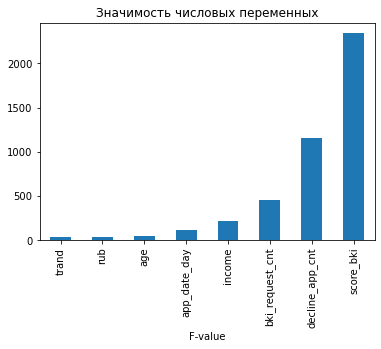

In [30]:
num_imp = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
num_imp.sort_values(inplace = True)
num_imp.plot(kind = 'bar')
plt.title('Значимость числовых переменных');
plt.xlabel('F-value');

Ожидаемо, самым важным признаком является 'score_bki'. То есть главное - это некий балл, присвоенный банком клиенту. На втором месте количество отказов, что тоже не удивительно.

### Бинарные признаки.

По аналогии с подготовительными материалами для бинарных признаков воспользуемся перекодировкой посредством класса LabelEncoder.

In [31]:
# Берём кодировищик, чтобы заменить все M на 1, все W на 0, и так далее.
bin_encoder = LabelEncoder()

# И тренеровочный и тестовый наборы изменяем.
for column in bin_cols:
    train[column] = bin_encoder.fit_transform(train[column])
    test[column] = bin_encoder.fit_transform(test[column])

### Значимость бинарных признаков.

Для того чтобы выявить значимость бинарных признаков с помощью mutual_info_classif.

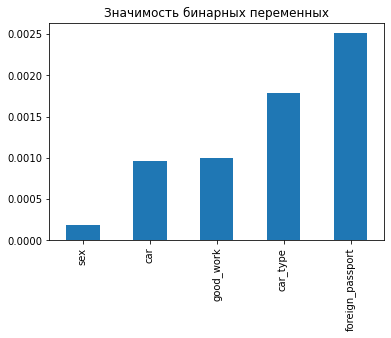

In [32]:
bin_imp = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features=True), index = bin_cols)
bin_imp.sort_values(inplace = True)
bin_imp.plot(kind = 'bar');
plt.title('Значимость бинарных переменных');

В данном случае важным признаком является наличие загран. паспорта. Тип машины тоже важен. Наверное, к владельцам иномарок больше банки расположены.

### Подготовка для категориальных признаков.

Для признака образования создадим дамми переменные.

In [33]:
# Сначала преобразуем признак образование в понятные числа.
cat_encoder = LabelEncoder()
train.education = cat_encoder.fit_transform(train.education)
test.education = cat_encoder.fit_transform(test.education)

Проверим, что получилось.

In [34]:
print('Тренеровочный набор.')
train.head()

Тренеровочный набор.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,app_date_day,app_date_dweek,app_date_month,rub,trand
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,9.798183,4,1,0,0,31,5,2,35.11,1.054354
1,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,10.308986,1,4,1,0,31,5,2,35.11,1.054354
2,25947,2014-02-01,1,1,3.737670,0,0,0.000000,1,-2.166293,...,9.392745,1,3,0,0,31,5,2,35.11,1.054354
3,25572,2014-02-01,3,0,3.761200,1,0,0.000000,0,-2.594199,...,10.165890,4,1,0,0,31,5,2,35.11,1.054354
4,25646,2014-02-01,3,0,3.988984,0,0,0.000000,0,-2.508767,...,10.308986,1,3,0,0,31,5,2,35.11,1.054354


In [35]:
print('Тестовый набор.')
test.head()

Тестовый набор.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,app_date_day,app_date_dweek,app_date_month,rub,trand
0,74835,2014-02-01,1,1,3.401197,1,1,0.000000,0,-2.271884,...,2,10.819798,1,4,0,31,5,2,35.11,1.054354
1,75683,2014-02-01,4,1,3.931826,1,1,0.000000,0,-1.691339,...,2,10.308986,1,3,1,31,5,2,35.11,1.054354
2,106331,2014-02-01,3,0,3.737670,0,0,0.000000,0,-2.800324,...,3,10.596660,2,2,0,31,5,2,35.11,1.054354
3,86253,2014-02-01,3,1,3.178054,0,0,0.693147,0,-2.784103,...,3,10.308986,1,2,0,31,5,2,35.11,1.054354
4,60455,2014-02-01,1,1,3.610918,0,0,0.000000,0,-1.454279,...,3,10.819798,4,2,0,31,5,2,35.11,1.054354


### Значимость категориальных признаков.

Для того чтобы выявить значимость бинарных признаков с помощью mutual_info_classif.

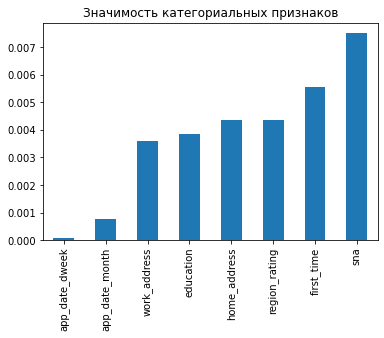

In [36]:
# Значимость категориальных признаков
imp_cat = pd.Series(mutual_info_classif(train[cat_cols], train['default'], discrete_features=True), index = train[cat_cols].columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'bar')
plt.title('Значимость категориальных признаков');

Как видно из результатов, наиболее важным признаком является "sna". В свою очередь признак дня недели практически ничего не значит. Предлагаю его убрать.

In [37]:
train = train.drop(['app_date_dweek'], axis=1)
test = test.drop(['app_date_dweek'], axis=1)
cat_cols.remove('app_date_dweek')

Проверим, что получилось.

In [38]:
print('Тренеровочный набор.')
train.head()

Тренеровочный набор.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,app_date_day,app_date_month,rub,trand
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,2,9.798183,4,1,0,0,31,2,35.11,1.054354
1,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,2,10.308986,1,4,1,0,31,2,35.11,1.054354
2,25947,2014-02-01,1,1,3.737670,0,0,0.000000,1,-2.166293,...,2,9.392745,1,3,0,0,31,2,35.11,1.054354
3,25572,2014-02-01,3,0,3.761200,1,0,0.000000,0,-2.594199,...,3,10.165890,4,1,0,0,31,2,35.11,1.054354
4,25646,2014-02-01,3,0,3.988984,0,0,0.000000,0,-2.508767,...,2,10.308986,1,3,0,0,31,2,35.11,1.054354


In [39]:
print('Тестовый набор.')
test.head()

Тестовый набор.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,app_date_day,app_date_month,rub,trand
0,74835,2014-02-01,1,1,3.401197,1,1,0.000000,0,-2.271884,...,1,2,10.819798,1,4,0,31,2,35.11,1.054354
1,75683,2014-02-01,4,1,3.931826,1,1,0.000000,0,-1.691339,...,1,2,10.308986,1,3,1,31,2,35.11,1.054354
2,106331,2014-02-01,3,0,3.737670,0,0,0.000000,0,-2.800324,...,1,3,10.596660,2,2,0,31,2,35.11,1.054354
3,86253,2014-02-01,3,1,3.178054,0,0,0.693147,0,-2.784103,...,2,3,10.308986,1,2,0,31,2,35.11,1.054354
4,60455,2014-02-01,1,1,3.610918,0,0,0.000000,0,-1.454279,...,2,3,10.819798,4,2,0,31,2,35.11,1.054354


Воспользуемся классом OneHotEncoder и подготовим векторы бинарных признаков для каждой строчки.

In [40]:
# Подготовим расширенные векторы для каждого категориального признака,
# чтоб не было отношения порядка.
train_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
test_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

## 3. Машинное обучение

In [41]:
# Новые признаки
poly = PolynomialFeatures(1) # Я экспериментировал и с 2 и 3.

x_train = poly.fit_transform(train[num_cols].values)
x_test = poly.fit_transform(test[num_cols].values)

Выполняем стандартизацию признаков.

In [42]:
train_num = StandardScaler().fit_transform(x_train)
test_num = StandardScaler().fit_transform(x_test)

# Посмотрим, что получилось.
print(train_num)
print(test_num)

[[ 0.          1.71113664 -0.42001208 ...  1.99740875 -0.20073675
  -0.93505217]
 [ 0.         -1.39343857  2.60673323 ...  1.99740875 -0.20073675
  -0.93505217]
 [ 0.          0.28882861 -0.42001208 ...  1.99740875 -0.20073675
  -0.93505217]
 ...
 [ 0.         -0.25190781 -0.42001208 ... -0.72668337 -2.60199891
  -1.90013286]
 [ 0.         -0.25190781 -0.42001208 ... -0.72668337 -2.60199891
  -1.90013286]
 [ 0.         -1.39343857 -0.42001208 ... -0.72668337 -2.60199891
  -1.90013286]]
[[ 0.         -0.88333898 -0.416391   ...  2.00469647 -0.2063808
  -0.93879   ]
 [ 0.          0.97850869 -0.416391   ...  2.00469647 -0.2063808
  -0.93879   ]
 [ 0.          0.29726165 -0.416391   ...  2.00469647 -0.2063808
  -0.93879   ]
 ...
 [ 0.         -1.00229142 -0.416391   ... -0.73418891 -2.61574609
  -1.90731071]
 [ 0.          1.82959949 -0.416391   ... -0.73418891 -2.61574609
  -1.90731071]
 [ 0.         -0.05390727 -0.416391   ... -0.73418891 -2.61574609
  -1.90731071]]


И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [43]:
# Объединение.
X = np.hstack([train_num, train[bin_cols].values, train_cat])   # Здесь мы будем учиться.
Y = train['default'].values                                     # А на этом проверяться.

X_exam = np.hstack([test_num, test[bin_cols].values, test_cat]) # А на этом будем экзаменоваться.

In [44]:
# Посмотрим что получилось.
X_exam.shape, X.shape, Y.shape

((36349, 44), (73799, 44), (73799,))

Сделаем разделение. Заметим, что train_test_split по умолчанию не делает стратифицированное разделение.
Поэтому для несбалансированного набора я считаю лучше подойдёт вот этот метод StratifiedShuffleSplit.

In [45]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, train['default']):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]

Проверим, как получилось.

In [46]:
print(f'Доля тренеровочного набора: {np.mean(Y_train)};')
print(f'Доля тестового набора: {np.mean(Y_test)}.')

Доля тренеровочного набора: 0.12700079608394452;
Доля тестового набора: 0.12696476964769648.


Как видим, побилось шикарно - подвыборки стратифицированы, доли с очень хорошей точностью совпадают между собой и долей в полном наборе данных.

## Тезисно: как буду обучать.

Моя идея состоит в том, чтоб построить классификатор с голосованием. Будет сделана попытка генерации нескольких классификаторов, таких как: логистическая регрессия, стохастический градиентный классификатор, случайный лес, наивный баейсовский, метод ближайших соседей и опорные вектора. Дальше мы выберем лучшие и их объединим в классификаторе VotingClassifier.

Приступим.

## 3.1. Логистическая регрессия.

#### Очень важно: библиотека sklearn, которая в Kaggle установлена, пытается декодировать уже декодированные данные. Чтобы я смог решить задачу, мне пришлось изменить солвер и тип штрафа. Подробности обсуждаются [тут]( https://stackoverflow.com/questions/65682019/attributeerror-str-object-has-no-attribute-decode-in-fitting-logistic-regre?form=MY01SV&OCID=MY01SV).

Попробуем обучить линейную регрессию на тренеровочном наборе. Для последовательного анализа в этом блоке буду не буду пользоваться функциями.

In [47]:
lgr_model = LogisticRegression(random_state=42)

Оценивать производительность классификаторов сложнее, чем регрессоров. Хороший способ оценки предсматривает применение перекрёстной проверки. Для обучения воспользуемся функцией cross_val_predict. Здесь выполняется перекрёстная проверка по К блокам и возвращает прогноз для каждого образца.

In [48]:
Y_train_pred = cross_val_predict(lgr_model, X_train, Y_train, cv=10)

Посмотрим, что получилось, по экурэси (accuracy), точности, полноте.
Здесь и далее будем понимать под **точностью** параметр **precision**, а про экурэси скоро забудем, и сейчас объясним почему.

In [49]:
print(classification_report(Y_train, Y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      0.876     0.995     0.932     51541
           1      0.484     0.030     0.056      7498

    accuracy                          0.873     59039
   macro avg      0.680     0.513     0.494     59039
weighted avg      0.826     0.873     0.821     59039



А теперь посмотрим матрицу неточности.

In [50]:
print(confusion_matrix(Y_train , Y_train_pred))

[[51303   238]
 [ 7275   223]]


Так что же мы имеем. Не смотря на высокую оценку экурэси 87% мы имеем очень малую полноту - около 3%. То есть мы дали кредит 97% дефолтным клиентам. Это значит, экурэси вообще ничего не значит на несбалансированном наборе. Поэтому в дальнейшем мы смотрим только на настояющую точость и полноту, и ещё один параметр, о котором позже.

А теперь попробуем с помощью решётчатого поиска подстроить гиперпараметры.

### Важно, так как решётчатый поиск подразумевает процесс подстройки модели под все возможные комбинации гиперпараметров, то этот процесс может быть очень длительным. Ниже приведён код (закомментированный), который при выбранных вариациях гиперпараметров даёт лучшую модель. Для ускорения процесса, ниже приведён конструктор классификатора с оптимальными параметрами для этой задачи, а так же выполняется обучение модели.

In [51]:
## С параметрами по умолчанию.
#olgr_model = LogisticRegression(random_state=42)
#
#iter_ = 50
#epsilon_stop = 1e-3
#
### Какие параметры будем перебирать
#param_grid = [
#    {'penalty': ['l1', 'l2'], 
#     'solver': ['liblinear', 'lbfgs'], 
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr'], 
#     'max_iter':[iter_],
#     'tol':[epsilon_stop]},
#    {'penalty': ['l1', 'l2'], 
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr'], 
#     'max_iter':[iter_],
#     'tol':[epsilon_stop]},
#    {'penalty': ['none'], 
#     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#     'class_weight':['none', 'balanced'], 
#     'multi_class': ['auto','ovr'], 
#     'max_iter':[iter_],
#     'tol':[epsilon_stop]},
#]
#
## Инициализируем.
#gridsearch = GridSearchCV(olgr_model, param_grid, scoring='f1', n_jobs=-1, cv=5)
#
## Запускаем.
#gridsearch.fit(X_train, Y_train)
#olgr_model = gridsearch.best_estimator_
#
## Посмотрим какие параметры лучшие.
#best_parameters = olgr_model.get_params()
#for param_name in sorted(best_parameters.keys()):
#        print('\t%s: %r' % (param_name, best_parameters[param_name]))
        
# Чтоб не потерять.
#	C: 1.0
#	class_weight: 'balanced'
#	dual: False
#	fit_intercept: True
#	intercept_scaling: 1
#	l1_ratio: None
#	max_iter: 50
#	multi_class: 'auto'
#	n_jobs: None
#	penalty: 'l2'
#	random_state: 42
#	solver: 'saga'
#	tol: 0.001
#	verbose: 0
#	warm_start: False



# Ради экономии времени.
olgr_model = LogisticRegression(random_state=42,
                                C=1.0,
                                class_weight='balanced',
                                dual=False,
                                fit_intercept=True,
                                intercept_scaling=1,
                                l1_ratio=None,
                                max_iter=50,
                                multi_class='auto',
                                n_jobs=None,
                                penalty='l2',
                                solver='liblinear', #'saga',
                                tol=0.001,
                                verbose=0,
                                warm_start=False)

# Обучаем.
olgr_model.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', max_iter=50, random_state=42,
                   solver='liblinear', tol=0.001)

In [52]:
# Строим прогноз.
Y_train_pred = olgr_model.predict(X_train)

Проверим, как изменились оценки.

In [53]:
print(classification_report(Y_train, Y_train_pred, digits=3))

              precision    recall  f1-score   support

           0      0.933     0.671     0.780     51541
           1      0.228     0.669     0.340      7498

    accuracy                          0.671     59039
   macro avg      0.581     0.670     0.560     59039
weighted avg      0.844     0.671     0.725     59039



И матрица неточностей.

In [54]:
print(confusion_matrix(Y_train , Y_train_pred))

[[34569 16972]
 [ 2479  5019]]


Как видно из результатов, полнота подтянулась до ~67%, это значит, что мы больше половины дефолтных обнаружили. Стало лучше.
Так же среднее гармоническое f1 тоже увеличилось в 11 раз. Кажется получилось!

### Посмотрим ещё на эту модель.

Отступление. Идея следующая, я хочу исследовать, как изменяется полнота и точность от пороговых значений.

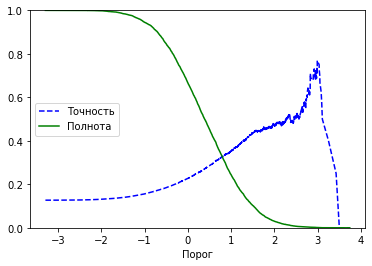

In [55]:
# Вычисляем суммы очков.
Y_scores = cross_val_predict(olgr_model, X_train, Y_train, cv=10, method= 'decision_function')

# Вычисляем точности, полноты как функции от очков.
precisions, recalls, thresholds = precision_recall_curve(Y_train, Y_scores)

# Рисуем графики.
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

То что, у нас точность так неравномерно растёт (а потом падает) с увеличением порога не должно пугать. Такое поведение хорошо было объяснено в книге О. Жерона: Прикладное машинное обучение с помощью scikit-learn и tensorflow. Но в любом случае при увеличении порога получаем падение полноты. Это неизбежно. Глядя на график, можно увидеть, что наша модель соответствует по точности и полноте точке пересечения двух графиков.
При других гиперпараметрах, я получал, что при максимальном пороге точноть была равна 1. Здесь же похоже классификатор настолько интересный, что при повышении порога перестаёт узнавать дефолтные образцы.

Нарисуем ещё графиков.

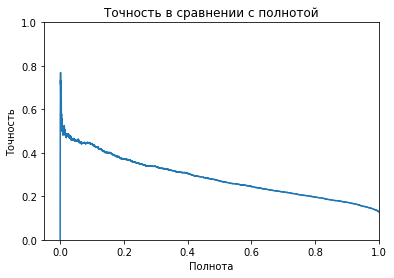

In [56]:
plt.plot(recalls[:-1], precisions[:-1])
plt.ylim([0, 1])
plt.xlim([-0.05, 1])
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Точность в сравнении с полнотой')
plt.show()

Зависимость почти линейная. На основе этого графика можно подобрать более выгодную стратегию отсеваиния. Но это в следующий раз.

А теперь вернёмся. Построим рабочую хахарктеристику приёмника (ROC) и вычислим площадь под кривой - AUC.

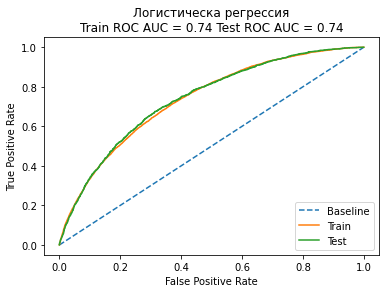

In [57]:
Y_olgr_train_prob = olgr_model.predict_proba(X_train)
Y_olgr_train_prob = Y_olgr_train_prob[:,1]
Y_olgr_test_prob = olgr_model.predict_proba(X_test)
Y_olgr_test_prob = Y_olgr_test_prob[:,1]


olgr_train_fpr, olgr_train_tpr, olgr_train_threshold = roc_curve(Y_train, Y_olgr_train_prob)
train_roc_auc = roc_auc_score(Y_train, Y_olgr_train_prob)

olgr_test_fpr, olgr_test_tpr, olgr_test_threshold = roc_curve(Y_test, Y_olgr_test_prob)
test_roc_auc = roc_auc_score(Y_test, Y_olgr_test_prob)


plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(olgr_train_fpr, olgr_train_tpr, label = 'Train')
plt.plot(olgr_test_fpr, olgr_test_tpr, label = 'Test')
plt.title(f'Логистическа регрессия\nTrain ROC AUC = {round(train_roc_auc, 2)} Test ROC AUC = {round(test_roc_auc, 2)}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Как видим, модель хорошо работает на тестовом и тренеровочном наборах. Хотелось бы, чтоб кривая была выше и ближе к левому верхнему углу. Но что поделаешь.

Что у нас с остальным? Смотрим.

In [58]:
# Строим прогноз.
Y_test_pred = olgr_model.predict(X_test)

In [59]:
print(classification_report(Y_test, Y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.936     0.674     0.783     12886
           1      0.234     0.685     0.348      1874

    accuracy                          0.675     14760
   macro avg      0.585     0.679     0.566     14760
weighted avg      0.847     0.675     0.728     14760



In [60]:
######### А это, что было на тренеровочном наборе.
#              precision    recall  f1-score   support
#
#           0      0.933     0.671     0.780     51541
#           1      0.228     0.669     0.340      7498
#
#    accuracy                          0.671     59039
#   macro avg      0.581     0.670     0.560     59039
#weighted avg      0.844     0.671     0.725     59039

In [61]:
print(confusion_matrix(Y_test , Y_test_pred))

[[8679 4207]
 [ 591 1283]]


Как видим, всё хорошо, мы не переобучили, что уже хорошо. Вроде всё получилось с логистической регрессией.

В дальнейшем мы пострим ещё модели, но будем пытаться для экономии времени сразу искать оптимальные гиперпараметры, пользоваться функциями. Дальше будем строить ROC, вычислять ROC AUC, матрицы неточностей, и так далее без изысков. Приступим!

## 3.2. Стохастический градиентный спуск.

Попробуем, начинаем строить оптимальную модель.

### *Важно!*
### В качестве функции потери будем использовать модифицированную функцию Хубера, так как она позволяет включить у СГС функцию predict_proba для отбора вероятностей. Этот выбор важен, так как в дальнейшем мы возможно будем использовать эту функцию при построении модели VotingClassifier.

### По аналогичным причинам ниже приведён код (закомментированный), который при выбранных вариациях гиперпараметров даёт лучшую модель. Для ускорения процесса, ниже приведён конструктор классификатора с оптимальными параметрами для этой задачи, а так же выполняется обучение модели.

In [62]:
## С параметрами по умолчанию.
#param_grid = {
#    'loss' : ['modified_huber', 'log'],
#    'alpha' : [0.01, 0.2, 1, 50],
#    'penalty' : ['l2', 'l1', 'none'],
#}
#
## Инициализируем.
#osgd_model = SGDClassifier(max_iter=500, random_state=42, tol=0.0001)
#gridsearch = GridSearchCV(osgd_model, param_grid, scoring='f1', n_jobs=-1, cv=10)
#
## Запускаем.
#gridsearch.fit(X_train, Y_train)
#osgd_model = gridsearch.best_estimator_
#
#
## Посмотрим какие параметры лучшие.
#best_parameters = osgd_model.get_params()
#for param_name in sorted(best_parameters.keys()):
#        print('\t%s: %r' % (param_name, best_parameters[param_name]))
        
# Чтоб не потерять.
#	alpha: 1
#	average: False
#	class_weight: None
#	early_stopping: False
#	epsilon: 0.1
#	eta0: 0.0
#	fit_intercept: True
#	l1_ratio: 0.15
#	learning_rate: 'optimal'
#	loss: 'modified_huber'
#	max_iter: 500
#	n_iter_no_change: 5
#	n_jobs: None
#	penalty: 'none'
#	power_t: 0.5
#	random_state: 42
#	shuffle: True
#	tol: 0.0001
#	validation_fraction: 0.1
#	verbose: 0
#	warm_start: False

# Ради экономии времени.
osgd_model = SGDClassifier(max_iter=500,
                           random_state=42,
                           alpha=1,
                           average=False,
                           class_weight=None,
                           early_stopping=False,
                           epsilon=0.1,
                           eta0=0.0,
                           fit_intercept=True,
                           l1_ratio=0.15,
                           learning_rate='optimal',
                           loss='modified_huber',
                           n_iter_no_change=5,
                           n_jobs=None,
                           penalty='none',
                           power_t=0.5,
                           shuffle=True,
                           tol=0.0001,
                           validation_fraction=0.1,
                           verbose=0,
                           warm_start=False)

# Обучаем.
osgd_model.fit(X_train, Y_train)

SGDClassifier(alpha=1, loss='modified_huber', max_iter=500, penalty='none',
              random_state=42, tol=0.0001)

Начинаем оценивать.

In [63]:
# Посмотрим, как обучились.
standart_scores(X_train, Y_train, osgd_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.889     0.902     0.895     51541
           1      0.248     0.223     0.235      7498

    accuracy                          0.816     59039
   macro avg      0.568     0.562     0.565     59039
weighted avg      0.807     0.816     0.811     59039

Матрица неточностей
[[46480  5061]
 [ 5827  1671]]


Посмотрим, что теперь у нас будет с испытательным набором.

In [64]:
# Валидация на тестовом наборе.
standart_scores(X_test, Y_test, osgd_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.889     0.909     0.899     12886
           1      0.262     0.223     0.241      1874

    accuracy                          0.822     14760
   macro avg      0.576     0.566     0.570     14760
weighted avg      0.810     0.822     0.815     14760

Матрица неточностей
[[11712  1174]
 [ 1457   417]]


Норма. Попробуем отрисовать графики и посмотрим, что там.

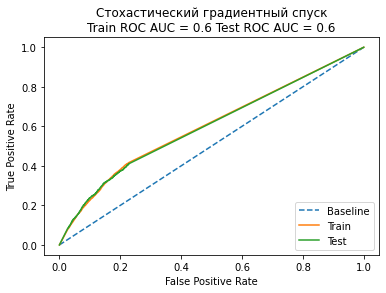

In [65]:
# Заведём переменные
osgd_train_fpr = 0
osgd_train_tpr = 0
osgd_test_fpr = 0
osgd_test_tpr = 0
plot_roc(X_train, Y_train, X_test, Y_test,
         osgd_train_fpr, osgd_train_tpr,
         osgd_test_fpr, osgd_test_tpr,
         osgd_model, 'Стохастический градиентный спуск')

Результаты хуже, чем в линейной регресси. Но модель хорошо обобщилась; переобучения не наблюдается! Обучили хорошо.
Дадим шанс слабому ученику.

## 3.3. Случайный лес.

Попробуем, начинаем строить оптимальную модель.

### Ниже приведён код (закомментированный), который при выбранных вариациях гиперпараметров даёт лучшую модель. Для ускорения процесса, ниже приведён конструктор классификатора с оптимальными параметрами для этой задачи, а так же выполняется обучение модели. Данная модель очень долго выполняла подгон гиперпараметров (более 4 часов), поэтому настоятельно рекомендую пользоваться предложенной выше схемой.
### *Важно!* Так же обратим внимание, что лучшая модель достигается для данной вариации гиперпараметров для максимальной глубины равной 8. Но в силу того, что при данном параметре модель переобучалась на тренеровочных данных, мне пришлось несколько упростить модель - гиперпараметр max_depth = 6.

In [66]:
## С параметрами по умолчанию.
#param_grid = { 
#    'n_estimators': [200, 500],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [4, 5, 6, 7, 8],
#    'criterion' :['gini', 'entropy']
#}
#
## Инициализируем.
#ofst_model = RandomForestClassifier(random_state=42, class_weight = 'balanced')
#gridsearch = GridSearchCV(ofst_model, param_grid=param_grid, n_jobs=-1, cv=10, scoring = 'f1')
#
## Запускаем.
#gridsearch.fit(X_train, Y_train)
#ofst_model = gridsearch.best_estimator_
#
#
## Посмотрим какие параметры лучшие.
#best_parameters = ofst_model.get_params()
#for param_name in sorted(best_parameters.keys()):
#        print('\t%s: %r' % (param_name, best_parameters[param_name]))
        

# Чтоб не потерять.        
#	bootstrap: True
#	ccp_alpha: 0.0
#	class_weight: 'balanced'
#	criterion: 'entropy'
#	max_depth: 8
#	max_features: 'log2'
#	max_leaf_nodes: None
#	max_samples: None
#	min_impurity_decrease: 0.0
#	min_impurity_split: None
#	min_samples_leaf: 1
#	min_samples_split: 2
#	min_weight_fraction_leaf: 0.0
#	n_estimators: 500
#	n_jobs: None
#	oob_score: False
#	random_state: 42
#	verbose: 0
#	warm_start: False

# Вот здесь, действительно, ради экономии времени.
ofst_model = RandomForestClassifier(random_state=42,
                                    class_weight = 'balanced',
                                    bootstrap=True,
                                    ccp_alpha=0.0,
                                    criterion='entropy',
                                    max_depth=6,
                                    max_features='log2',
                                    max_leaf_nodes=None,
                                    max_samples=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=500,
                                    n_jobs=None,
                                    oob_score=False,
                                    verbose=0,
                                    warm_start=False)

# Обучаем.
ofst_model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features='log2', n_estimators=500,
                       random_state=42)

Тренеровочный набор.

In [67]:
# Посмотрим, как обучились.
standart_scores(X_train, Y_train, ofst_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.933     0.688     0.792     51541
           1      0.235     0.660     0.347      7498

    accuracy                          0.684     59039
   macro avg      0.584     0.674     0.569     59039
weighted avg      0.844     0.684     0.735     59039

Матрица неточностей
[[35462 16079]
 [ 2549  4949]]


Испытательный набор.

In [68]:
# Валидация на тестовом наборе.
standart_scores(X_test, Y_test, ofst_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.934     0.689     0.793     12886
           1      0.238     0.665     0.350      1874

    accuracy                          0.686     14760
   macro avg      0.586     0.677     0.572     14760
weighted avg      0.846     0.686     0.737     14760

Матрица неточностей
[[8883 4003]
 [ 627 1247]]


В целом наблюдается небольшое улучшение, но в силу того, что оно незначительное, будем считать, что всё хорошо. В принципе - норма.

Графики ROC.

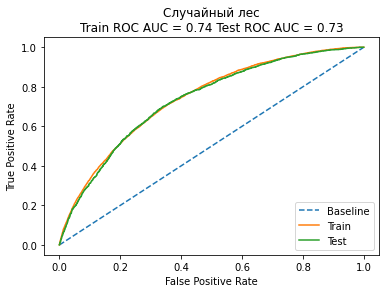

In [69]:
# Заведём переменные
ofst_train_fpr = 0
ofst_train_tpr = 0
ofst_test_fpr = 0
ofst_test_tpr = 0
plot_roc(X_train, Y_train, X_test, Y_test,
         ofst_train_fpr, ofst_train_tpr,
         ofst_test_fpr, ofst_test_tpr,
         ofst_model, 'Случайный лес')

Будем считать, что всё хорошо.

## 3.4. Наивный байесовский.

Попробуем, начинаем строить оптимальную модель. Данная модель является классической, одной из самых простых. Посмотрим, как она себя поведёт. Так как он прост, то решётчатый поиск выполним в полном объёме с диагностикой.

In [70]:
# С параметрами по умолчанию.
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Инициализируем.
ognb_model = GaussianNB()
gridsearch = GridSearchCV(ognb_model, param_grid=param_grid, n_jobs=-1, cv=10, scoring = 'f1', verbose=2)

# Запускаем.
gridsearch.fit(X_train, Y_train)
ognb_model = gridsearch.best_estimator_


# Посмотрим какие параметры лучшие.
best_parameters = ognb_model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   28.7s


	priors: None
	var_smoothing: 6.579332246575683e-05


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.3s finished


Тренеровочный набор.

In [71]:
# Посмотрим, как обучились.
standart_scores(X_train, Y_train, ognb_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.912     0.780     0.841     51541
           1      0.243     0.486     0.324      7498

    accuracy                          0.742     59039
   macro avg      0.578     0.633     0.582     59039
weighted avg      0.827     0.742     0.775     59039

Матрица неточностей
[[40177 11364]
 [ 3857  3641]]


Точность на уровне СГС..

Что на испытательном наборе?

In [72]:
# Валидация на тестовом наборе.
standart_scores(X_test, Y_test, ognb_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.915     0.783     0.844     12886
           1      0.251     0.501     0.335      1874

    accuracy                          0.747     14760
   macro avg      0.583     0.642     0.589     14760
weighted avg      0.831     0.747     0.779     14760

Матрица неточностей
[[10086  2800]
 [  935   939]]


Обучились хорошо. Результаты входят в тройку лучших вместе со случайным лесом и логистической моделью.

Графики ROC.

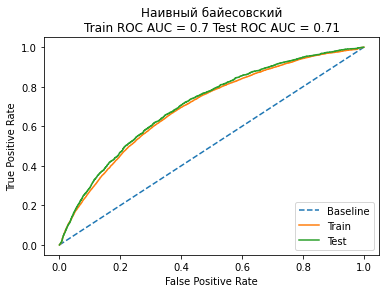

In [73]:
# Заведём переменные
ognb_train_fpr = 0
ognb_train_tpr = 0
ognb_test_fpr = 0
ognb_test_tpr = 0
plot_roc(X_train, Y_train, X_test, Y_test,
         ognb_train_fpr, ognb_train_tpr,
         ognb_test_fpr, ognb_test_tpr,
         ognb_model, 'Наивный байесовский')

Тоже всё хорошо. Всё отлично. Супер.

## 3.5. N ближайших соседей.

Данную модель также обучим в полном объёме. Приступим.

In [74]:
# С параметрами по умолчанию.
param_grid = {'n_neighbors': np.arange(2, 3)}

# Инициализируем.
oknn_model = KNeighborsClassifier()
gridsearch = GridSearchCV(oknn_model, param_grid=param_grid, n_jobs=-1, cv=10, scoring = 'f1')

# Запускаем.
gridsearch.fit(X_train, Y_train)
oknn_model = gridsearch.best_estimator_


# Посмотрим какие параметры лучшие.
best_parameters = oknn_model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
        
#	algorithm: 'auto'
#	leaf_size: 30
#	metric: 'minkowski'
#	metric_params: None
#	n_jobs: None
#	n_neighbors: 2
#	p: 2
#	weights: 'uniform'        

	algorithm: 'auto'
	leaf_size: 30
	metric: 'minkowski'
	metric_params: None
	n_jobs: None
	n_neighbors: 2
	p: 2
	weights: 'uniform'


Тренеровочный набор.

In [75]:
# Посмотрим, как обучились.
standart_scores(X_train, Y_train, oknn_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.896     1.000     0.945     51541
           1      1.000     0.199     0.332      7498

    accuracy                          0.898     59039
   macro avg      0.948     0.599     0.638     59039
weighted avg      0.909     0.898     0.867     59039

Матрица неточностей
[[51541     0]
 [ 6006  1492]]


Как получилось красиво, всех нормальных клиентов алгоритм смог опознать. Но полнота не блещет. Что же на испытательном наборе выйдет? Я догадываюсь уже..

In [76]:
# Валидация на тестовом наборе.
standart_scores(X_test, Y_test, oknn_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.876     0.980     0.925     12886
           1      0.247     0.045     0.077      1874

    accuracy                          0.861     14760
   macro avg      0.561     0.513     0.501     14760
weighted avg      0.796     0.861     0.817     14760

Матрица неточностей
[[12627   259]
 [ 1789    85]]


Собственно результат налицо.

Графики ROC.

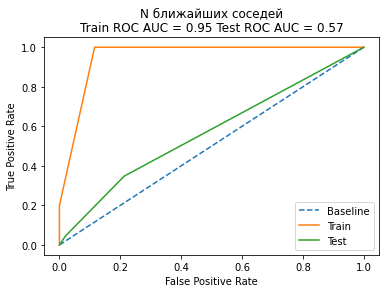

In [77]:
# Заведём переменные
oknn_train_fpr = 0
oknn_train_tpr = 0
oknn_test_fpr = 0
oknn_test_tpr = 0
plot_roc(X_train, Y_train, X_test, Y_test,
         oknn_train_fpr, oknn_train_tpr,
         oknn_test_fpr, oknn_test_tpr,
         oknn_model, 'N ближайших соседей')

Собственно и без графиков было видно очевидное переобучение, когда все параметры на испытательном наборе ухудшились. Эта модель не войдёт в дрим тим.

### Касательно данной модели: здесь я несколько раз пробовал разные вариации гиперпараметров, но я не смог получить сбалансированную модель, чтобы и качественные характеристики "не уплыли", и переобучения не случилось. Не вышло. Скорее всего у меня мало опыта.


*********************************

## 3.6. Опорные вектора.

### *Важно!*
### Чтобы модель опорных векторов смогла воспользоваться predict_proba, необходимо установить гиперпараметр probability в True. Этот выбор важен, так как в дальнейшем мы будем использовать эту функцию при построении модели VotingClassifier.


### А теперь о серьёзном. Данная модель очень хорошо подходит для различных наборов небольшого объёма данных. Модель очень вычислительно нагруженная, обучение происходит крайне медленно. Изначально я был полон оптимизма и надеялся, что за ночь решётчатый поиск найдёт оптимальную конфигурацию параметров, но все мои иллюзии рассеялись, когда даже за время большее, чем сутки, модель всё ещё обучалась. На основе оценки в книге О. Жерона можно сделать выводы о сложности данного алгоритма: $O(m^2*n)-O(m^3*n)$, где m - количество образцов, а n - количество признаков, я понял, что простейшее обучение (с линейным ядром) будет стоить около недели непрерывной работы. Увы, Булевар не вынес этого.
### Так же была мысль попробовать обучить на основе LinearSVC, но у данной модели не предусмотрен метод predict_proba. Но ради спортивного интереса, я попробовал обучить модель на основе LinearSVC, и, прождав 3 часа, понял, что пора завязывать.


In [78]:
# С параметрами по умолчанию.
#param_grid = {'C':[1,10,100,1000],
#              'gamma':[1,0.1,0.001,0.0001],
#              'kernel':['linear','rbf'],
##              'probability': [True]}
#
#param_grid = {'C':[1],
#              'gamma':[0.1],
#              'kernel':['rbf'],
#              'probability': [True]}
#
#
## Инициализируем.
#oscv_model = SVC(random_state=42)
#gridsearch = GridSearchCV(oscv_model, param_grid, refit = True, scoring='f1', n_jobs=-1, cv=5)
#
## Запускаем.
#gridsearch.fit(X_train, Y_train)
#oscv_model = gridsearch.best_estimator_
#
#
## optimal-parameters-forsvc-using-gridsearch
#
## Посмотрим какие параметры лучшие.
#best_parameters = oscv_model.get_params()
#for param_name in sorted(best_parameters.keys()):
#        print('\t%s: %r' % (param_name, best_parameters[param_name]))

#oscv_model = SVC(random_state=42,
#                 C=10,
#                 gamma=0.1,
#                 kernel='linear',
#                 probability=True)

#oscv_model = SVC(random_state=42)
#oscv_model.fit(X_train, Y_train)

In [79]:
#oscv_model.fit(X_train, Y_train)

Смотрим, что вышло на тренеровочном наборе.

In [80]:
# Посмотрим, как обучились.
#standart_scores(X_train, Y_train, osvc_model)

Посмотрим, что теперь у нас будет с испытательным набором.

In [81]:
# Валидация на тестовом наборе.
#standart_scores(X_test, Y_test, osvc_model)

Тоже хорошо.

Графики.

In [82]:
# Заведём переменные
#osvc_train_fpr = 0
#osvc_train_tpr = 0
#osvc_test_fpr = 0
#osvc_test_tpr = 0
#plot_roc(X_train, Y_train, X_test, Y_test,
#         osvc_train_fpr, osvc_train_tpr,
#         osvc_test_fpr, osvc_test_tpr,
#         osvc_model, 'Опорные вектора')

Как говорил доктор Хаус: - "Нужна лодка больше". Больше мощностей, больше времени, и тогда наверняка можно будет сделать конфетку.

*********************************

## 3.7. Классификатор с голосованием.

### *Важно!*
### Чтобы классификатор с голосованием мог исппользовать predict_proba, необходимо установить гиперпараметр voting в soft.

Итак, на основе выше приведённых результатов, попробуем построить несколько классификаторов:
* на основе всех реализованных моделей за исключением модели ближайшего соседа;
* на основе логистической регрессии и случайных деревьев, так они самые перспективные.


Строим, обучаем, валидируем.


In [83]:
# Создаём общий классификатор.
voting_all_model = VotingClassifier(estimators=[('lgr', olgr_model),
                                                ('sgd', osgd_model),
                                                ('fst', ofst_model),
                                                ('gnb', ognb_model)],
                                                 voting='soft')

# Обучаем.
voting_all_model.fit(X_train, Y_train)

VotingClassifier(estimators=[('lgr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=50, random_state=42,
                                                 solver='liblinear',
                                                 tol=0.001)),
                             ('sgd',
                              SGDClassifier(alpha=1, loss='modified_huber',
                                            max_iter=500, penalty='none',
                                            random_state=42, tol=0.0001)),
                             ('fst',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=6,
                                                     max_features='log2',
                                                     n_estimators=500,
                 

In [84]:
# Посмотрим, как обучились.
standart_scores(X_train, Y_train, voting_all_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.909     0.834     0.870     51541
           1      0.271     0.423     0.330      7498

    accuracy                          0.782     59039
   macro avg      0.590     0.628     0.600     59039
weighted avg      0.828     0.782     0.801     59039

Матрица неточностей
[[43003  8538]
 [ 4329  3169]]


Проверим на испытательном наборе.

In [85]:
# Валидация на тестовом наборе.
standart_scores(X_test, Y_test, voting_all_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.910     0.836     0.871     12886
           1      0.277     0.433     0.338      1874

    accuracy                          0.785     14760
   macro avg      0.594     0.634     0.605     14760
weighted avg      0.830     0.785     0.804     14760

Матрица неточностей
[[10772  2114]
 [ 1063   811]]


Ну а теперь графики.

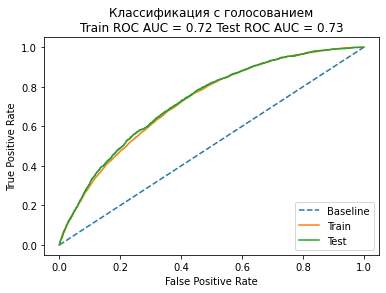

In [86]:
# Заведём переменные
voting_all_train_fpr = 0
voting_all_train_tpr = 0
voting_all_test_fpr = 0
voting_all_test_tpr = 0
plot_roc(X_train, Y_train, X_test, Y_test,
         voting_all_train_fpr, voting_all_train_tpr,
         voting_all_test_fpr, voting_all_test_tpr,
         voting_all_model, 'Классификация с голосованием')

В целом неплохо, но хуже чем логистическая регрессия. Попробуем улучшить результаты.

А теперь построим лучшую модель: в неё войдёт логистическая регрессия, случайные леса. Вперёд.

In [87]:
# Создаём классификатор.
best_model = VotingClassifier(estimators=[('lgr', olgr_model),
                                          ('fst', ofst_model)],
                                          voting='soft')

# Обучаем.
best_model.fit(X_train, Y_train)

VotingClassifier(estimators=[('lgr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=50, random_state=42,
                                                 solver='liblinear',
                                                 tol=0.001)),
                             ('fst',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=6,
                                                     max_features='log2',
                                                     n_estimators=500,
                                                     random_state=42))],
                 voting='soft')

In [88]:
# Посмотрим, как обучились.
standart_scores(X_train, Y_train, best_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.934     0.677     0.785     51541
           1      0.232     0.670     0.345      7498

    accuracy                          0.677     59039
   macro avg      0.583     0.674     0.565     59039
weighted avg      0.845     0.677     0.729     59039

Матрица неточностей
[[34917 16624]
 [ 2471  5027]]


Проверим на испытательном наборе.

In [89]:
# Валидация на тестовом наборе.
standart_scores(X_test, Y_test, best_model)

Основные оценки
              precision    recall  f1-score   support

           0      0.936     0.679     0.787     12886
           1      0.235     0.680     0.350      1874

    accuracy                          0.679     14760
   macro avg      0.586     0.679     0.568     14760
weighted avg      0.847     0.679     0.731     14760

Матрица неточностей
[[8748 4138]
 [ 600 1274]]


Ну а теперь графики.

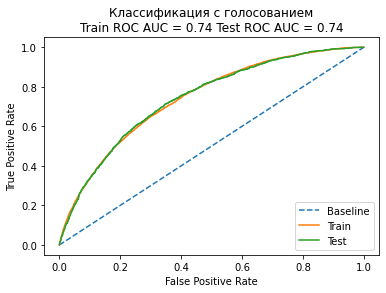

In [90]:
# Заведём переменные
best_train_fpr = 0
best_train_tpr = 0
best_test_fpr = 0
best_test_tpr = 0
plot_roc(X_train, Y_train, X_test, Y_test,
         best_train_fpr, best_train_tpr,
         best_test_fpr, best_test_tpr,
         best_model, 'Классификация с голосованием')

Красота. Как видно из представленных результатов, обученная модель хорошо обобщилась на испытательном наборе, и её будем использовать для продакшена. Чем она хороша? Тем, что она реализует две лучших модели для этого набора данных. Известно, что ансамблевые методы лучше, чем отдельно взятая модель ансамбля. Плюс случайный лес предполагает использование бэггинга.

## 4. Экзамен.

Готовим сабмишэн.

In [91]:
# Вычисляем вероятности принадлежности к классу дефолтных клиентов.
Y_exam_prob = best_model.predict_proba(X_exam)[:,1]

# Пишем файл.
submit = pd.DataFrame(test.client_id)
submit['default']=Y_exam_prob
submit.to_csv('submission.csv', index=False)

## По поводу команды, к сожалению, а может и к счатью, никто не подключился ко мне. Но я не расстраивался, так как моя команда - это я, жена и маленькие дети) 
## В дальнейшем попытаюсь добить опорные вектора и обновить результаты.
## Вот и всё. Надеюсь, вам понравилось.
## Спасибо за внимание!